In [11]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import tensorflow.keras.backend as K

In [12]:
class RetinalClassifier:
    def __init__(self, img_size=(224, 224), batch_size=32):
        self.img_size = img_size
        self.batch_size = batch_size
        self.model = None
        self.history = None


    def data_ingestion(self, train_dir, test_dir):
        """Initialize data generators with preprocessing"""
        try:
            # print("***********Starting Data Ingestion*************")
            
            self.train_datagen = ImageDataGenerator(
                preprocessing_function=self.preprocess_image,
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                horizontal_flip=True,
                vertical_flip=True,
                # zoom_range=0.2,
                # shear_range=0.2,
                # fill_mode='nearest',
                validation_split=0.2,
                rescale=None
            )
            
            self.test_datagen = ImageDataGenerator(
                preprocessing_function=self.preprocess_image,
                rescale=None
            )
            
            self.train_generator = self.train_datagen.flow_from_directory(
                train_dir,
                target_size=self.img_size,
                batch_size=self.batch_size,
                class_mode='binary',
                subset='training',
                shuffle=True,
                color_mode='rgb'
            )
            
            self.valid_generator = self.train_datagen.flow_from_directory(
                train_dir,
                target_size=self.img_size,
                batch_size=self.batch_size,
                class_mode='binary',
                subset='validation',
                color_mode='rgb'
            )
            
            self.test_generator = self.test_datagen.flow_from_directory(
                test_dir,
                target_size=self.img_size,
                batch_size=self.batch_size,
                class_mode='binary',
                color_mode='rgb'
            )
        
        except Exception as e:
            print(f"************Error during data ingestion: {str(e)}**************")
            raise
        
        return self.train_generator, self.valid_generator, self.test_generator


    def preprocess_image(self, image):
        """Apply preprocessing steps to a single image"""
        try:
            # print("*******************Starting Image Pre-processing**********************")
            
            # Convert image to uint8 if needed
            if image.max() <= 1.0:
                image = (image * 255).astype(np.uint8)

            # Ensure correct channel ordering
            if len(image.shape) == 3:
                if image.shape[2] == 4:  # Handle RGBA
                    image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
                green = image[:, :, 1]
            else:
                green = image
            
            # Convert to uint8 and ensure correct range
            green = cv2.normalize(green, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
            
            # Apply CLAHE
            clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
            clahe_output = clahe.apply(green)

            # Vessel enhancement
            vessels = self._frangi_filter(clahe_output)

            # Final enhancement
            enhanced = cv2.addWeighted(clahe_output, 0.7, vessels, 0.3, 0)
            enhanced_rgb = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2RGB)
        
        except Exception as e:
            print(f"****************Error during preprocessing: {str(e)}*******************")
            raise
        
        return enhanced_rgb / 255.0


    def _frangi_filter(self, image):
        """Apply Frangi filter for vessel enhancement"""
        try:
            # print("***********************Starting to apply Frangi Filter*************************")
            
            from skimage.filters import frangi
            vessels = frangi(
                image.astype(float),
                sigmas=range(1, 10, 2),
                black_ridges=False
            )
        except Exception as e:
            print(f"************************Error during applying frangi filter: {str(e)}************************")
            raise
        return ((vessels - vessels.min()) / (vessels.max() - vessels.min()) * 255).astype(np.uint8)


    def visualize_preprocessing_steps(self, image):
        """Visualize all preprocessing steps"""
        try:
            # print("******************Starting Pre=pro steps Visualization*************************")
            
            if image.max() <= 1.0:
                image = (image * 255).astype(np.uint8)
                
            # Store intermediate results
            results = {
                'Original': image,
                'Green Channel': image[:, :, 1] if len(image.shape) == 3 else image,
            }
            
            # CLAHE
            clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
            results['CLAHE'] = clahe.apply(results['Green Channel'])
            
            # Vessels
            results['Vessels'] = self._frangi_filter(results['CLAHE'])
            
            # Enhanced
            results['Enhanced'] = cv2.addWeighted(
                results['CLAHE'], 0.7,
                results['Vessels'], 0.3,
                0
            )
            
            # Visualization
            fig, axes = plt.subplots(1, 5, figsize=(20, 4))
            for ax, (title, img) in zip(axes, results.items()):
                if len(img.shape) == 2:
                    ax.imshow(img, cmap='gray')
                else:
                    ax.imshow(img)
                ax.set_title(title)
                ax.axis('off')
            plt.tight_layout()
            plt.show()
        
        except Exception as e:
            print(f"****************************Error during pre-pro steps visualization: {str(e)}****************************")
            raise


    def calculate_class_weights(self):
        """Calculate class weights based on training data distribution"""
        try:
            # print("*********************Calculating Class weights*************************")
            
            total_samples = len(self.train_generator.classes)
            n_samples = [np.sum(self.train_generator.classes == i) for i in range(2)]
            
            class_weights = {
                0: total_samples / (2 * n_samples[0]),
                1: total_samples / (2 * n_samples[1])
            }
        
        except Exception as e:
            print(f"**************************Error during calculating class weights: {str(e)}****************************")
            raise
        
        return class_weights


    def build_model(self, learning_rate=0.0001):
        """Build VGG16 model with custom top layers"""
        try:
            print("*****************************Building Model********************************")
            
            base_model = VGG16(
                weights='imagenet',
                include_top=False,
                input_shape=(*self.img_size, 3)
            )
            
            x = base_model.output
            x = GlobalAveragePooling2D()(x)
            
            x = Dense(512, activation='relu')(x)
            x = BatchNormalization()(x)
            x = Dropout(0.5)(x)
            
            x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
            x = BatchNormalization()(x)
            x = Dropout(0.3)(x)
            
            predictions = Dense(1, activation='sigmoid')(x)
            
            self.model = Model(inputs=base_model.input, outputs=predictions)
            
            # Freeze base layers
            for layer in base_model.layers:
                layer.trainable = False
            
            # Unfreeze some layers for fine-tuning
            # for layer in base_model.layers[-4:]:
            #     layer.trainable = True
            
            self.model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                loss='binary_crossentropy',
                metrics=[
                    'accuracy',
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall(),
                    tf.keras.metrics.AUC(curve='ROC', summation_method='interpolation')
                ]
            )
            
            print(self.model.summary())
        
        except Exception as e:
            print(f"*********************Error during model building: {str(e)}*********************")
            raise
        
        return self.model


    def train_model(self, epochs=20):
        """Train the model"""
        try:
            print("**************************Starting Model Training****************************")
            
            # Calculate class weights
            class_weights = self.calculate_class_weights()
            
            # Define callbacks
            callbacks = [
                tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=5,
                    restore_best_weights=True
                ),
                tf.keras.callbacks.ModelCheckpoint(
                    '../artifacts/model/trials/VGG16_v1.keras',
                    save_best_only=True,
                    monitor='val_loss'
                ),
                tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss',
                    factor=0.2,
                    patience=3,
                    min_lr=1e-6
                )
            ]
        
            # Train with class weights and callbacks
            self.history = self.model.fit(
                self.train_generator,
                validation_data=self.valid_generator,
                epochs=epochs,
                # class_weight=class_weights,
                callbacks=callbacks,
                # verbose=1
            )
        
        except Exception as e:
            print(f"***********************Error during model training: {str(e)}*****************************")
            raise
        
        return self.history


    def evaluate_model(self):
        """Evaluate model and print metrics"""
        try:
            print("*****************************Starting Model Evaluation*******************************")
            
            # Generate predictions
            y_pred = self.model.predict(self.test_generator)
            y_pred_classes = (y_pred > 0.5).astype(int)
            y_true = self.test_generator.classes
            
            # Calculate metrics
            print("\nClassification Report:")
            print(classification_report(y_true, y_pred_classes))
            
            # Confusion Matrix
            plt.figure(figsize=(8, 6))
            sns.heatmap(
                confusion_matrix(y_true, y_pred_classes),
                annot=True,
                fmt='d',
                cmap='Blues'
            )
            plt.title('Confusion Matrix')
            plt.show()
            
            # ROC Curve
            fpr, tpr, _ = roc_curve(y_true, y_pred)
            roc_auc = auc(fpr, tpr)
            
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, color='darkorange', lw=2,
                    label=f'ROC curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic')
            plt.legend(loc="lower right")
            plt.show()
        
        except Exception as e:
            print(f"*******************************Error during model evaluation: {str(e)}******************************")
            raise


    def generate_gradcam(self, image, layer_name='block5_conv3'):
        """Generate Grad-CAM heatmap for a single image"""
        try:
            print("**************************Starting GradCAM Generation***************************")
            
            img_array = np.expand_dims(self.preprocess_image(image), axis=0)
            
            grad_model = Model(
                inputs=[self.model.inputs],
                outputs=[self.model.get_layer(layer_name).output, self.model.output]
            )
            
            with tf.GradientTape() as tape:
                conv_outputs, predictions = grad_model(img_array)
                loss = predictions[:, 0]
                
            # Extract gradients
            grads = tape.gradient(loss, conv_outputs)
            pooled_grads = K.mean(grads, axis=(0, 1, 2))
            
            # Generate heatmap
            heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
            heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
            
            # Superimpose heatmap on original image
            heatmap = cv2.resize(heatmap[0], (image.shape[1], image.shape[0]))
            heatmap = np.uint8(255 * heatmap)
            heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
            
            superimposed = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)
            
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(image)
            plt.title('Original')
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.imshow(superimposed)
            plt.title('Grad-CAM')
            plt.axis('off')
            plt.show()
        
        except Exception as e:
            print(f"*******************************Error during gradCAM generation: {str(e)}******************************")
            raise


    def try_prediction(self, image_path):
        """
        Make prediction for a single image and visualize results
        
        Args:
            image_path (str): Path to the image file
            
        Returns:
            dict: Prediction results including probability and class
        """
        try:
            print("************************Starting Test Predictions for some samples**************************")
            
            # Load and preprocess image
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Could not load image from {image_path}")
                
            # Convert BGR to RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # Resize image
            image = cv2.resize(image, self.img_size)
            
            # Process image and make prediction
            processed = self.preprocess_image(image)
            prediction = self.model.predict(np.expand_dims(processed, axis=0), verbose=0)[0][0]
            
            # Create results dictionary
            results = {
                'probability': prediction,
                'class': 'Abnormal' if prediction > 0.5 else 'Normal',
                'threshold': 0.5
            }
            
            # Print results
            print("\nPrediction Results:")
            print("-" * 20)
            print(f"Probability: {results['probability']:.3f}")
            print(f"Class: {results['class']}")
            print(f"Threshold: {results['threshold']}")
            
            # Create figure with subplots
            plt.figure(figsize=(15, 5))
            
            # Original image
            plt.subplot(131)
            plt.imshow(image)
            plt.title('Original Image')
            plt.axis('off')
            
            # Preprocessed image
            plt.subplot(132)
            plt.imshow(processed)
            plt.title('Preprocessed Image')
            plt.axis('off')
            
            # GradCAM visualization
            plt.subplot(133)
            self.generate_gradcam(image)
            plt.title('GradCAM Heatmap')
            plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            # Show detailed preprocessing steps
            print("\nPreprocessing Steps Visualization:")
            self.visualize_preprocessing_steps(image)
            
            return results
            
        
        except Exception as e:
            print(f"*******************************Error during predictions: {str(e)}******************************")
            raise


    def visualize_batch_predictions(self, image_paths, num_samples=5):
        """
        Visualize predictions for multiple images
        
        Args:
            image_paths (list): List of paths to image files
            num_samples (int): Number of samples to visualize
        """
        try:
            # print("*****************************Starting Batch Pred. Visualization*****************************")
            
            # Sample random images if more than num_samples
            if len(image_paths) > num_samples:
                image_paths = np.random.choice(image_paths, num_samples, replace=False)
            
            results = []
            for path in image_paths:
                try:
                    result = self.try_prediction(path)
                    results.append({
                        'path': path,
                        **result
                    })
                except Exception as e:
                    print(f"Failed to process {path}: {str(e)}")
                    continue
            
            # Create summary table
            summary_df = pd.DataFrame(results)
            print("\nBatch Prediction Summary:")
            print(summary_df)
            
        except Exception as e:
            print(f"*******************************Error during visualizing batch predictions: {str(e)}******************************")
            raise
        
        return summary_df

In [13]:
train_dir = Path('../artifacts/dataset/train')
test_dir = Path('../artifacts/dataset/test')
img_sample_dir_0 = Path('../artifacts/dataset/test/0/IM5005EY.JPG')
img_sample_dir_1 = Path('../artifacts/dataset/test/1/032_01.1.060-1.02_L-06.JPG')

In [14]:
# Initialize classifier
classifier = RetinalClassifier()

# Load and preprocess data
train_gen, valid_gen, test_gen = classifier.data_ingestion(train_dir, test_dir)

Found 671 images belonging to 2 classes.
Found 167 images belonging to 2 classes.


Found 280 images belonging to 2 classes.


In [15]:
# Build and train model
model = classifier.build_model(learning_rate=0.0001)
history = classifier.train_model(epochs=10)

*****************************Building Model********************************


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       262,65

 Total params: 15,244,609 (58.15 MB)

 Trainable params: 527,873 (2.01 MB)

 Non-trainable params: 14,716,736 (56.14 MB)

None
**************************Starting Model Training****************************
Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 296s 14s/step - accuracy: 0.5520 - auc_2: 0.5643 - loss: 5.9521 - precision_2: 0.5809 - recall_2: 0.5699 - val_accuracy: 0.4731 - val_auc_2: 0.5785 - val_loss: 5.6156 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 288s 14s/step - accuracy: 0.5032 - auc_2: 0.5399 - loss: 5.7516 - precision_2: 0.5082 - recall_2: 0.5438 - val_accuracy: 0.4790 - val_auc_2: 0.5122 - val_loss: 5.4127 - val_precision_2: 1.0000 - val_recall_2: 0.0114 - learning_rate: 1.0000e-04
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 266s 13s/step - accuracy: 0.5147 - auc_2: 0.5226 - loss: 5.5492 - precision_2: 0.5439 - recall_2: 0.5454 - val_accuracy: 0.4790 - val_auc_2: 0.5398 - val_loss: 5.2199 - val_precision_2: 0.5161 - val_recall_2: 0.1818 - learning_rate: 1.0000e-04
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 273s 13s/step - accuracy:

*****************************Starting Model Evaluation*******************************
9/9 ━━━━━━━━━━━━━━━━━━━━ 96s 11s/step

Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.02      0.03       132
           1       0.52      0.95      0.67       148

    accuracy                           0.51       280
   macro avg       0.36      0.48      0.35       280
weighted avg       0.37      0.51      0.37       280



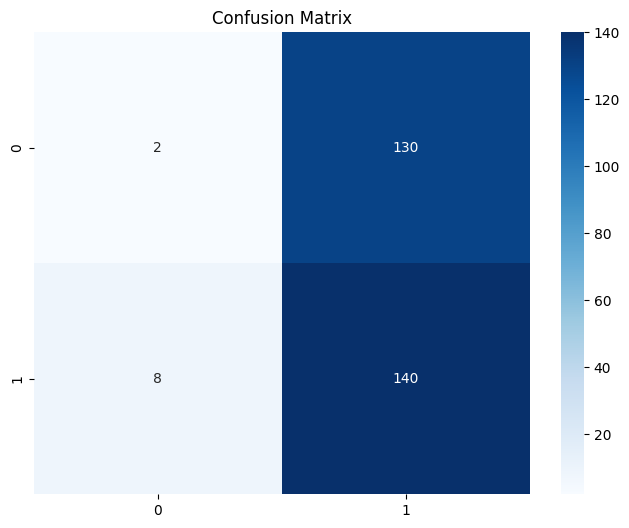

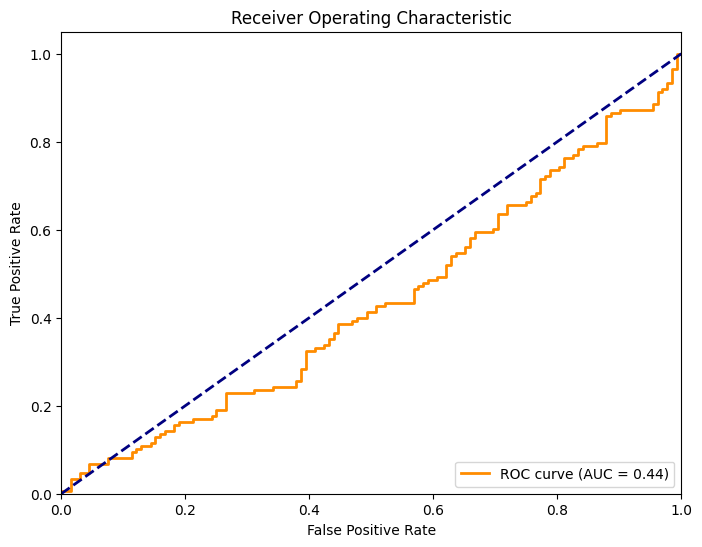

In [16]:
# Evaluate and visualize results
classifier.evaluate_model()

************************Starting Test Predictions for some samples**************************

Prediction Results:
--------------------
Probability: 0.587
Class: Abnormal
Threshold: 0.5
**************************Starting GradCAM Generation***************************


c:\Users\Hp\Documents\GitHub\cattle-cvd-via-retina-imgs\CVD\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_54']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


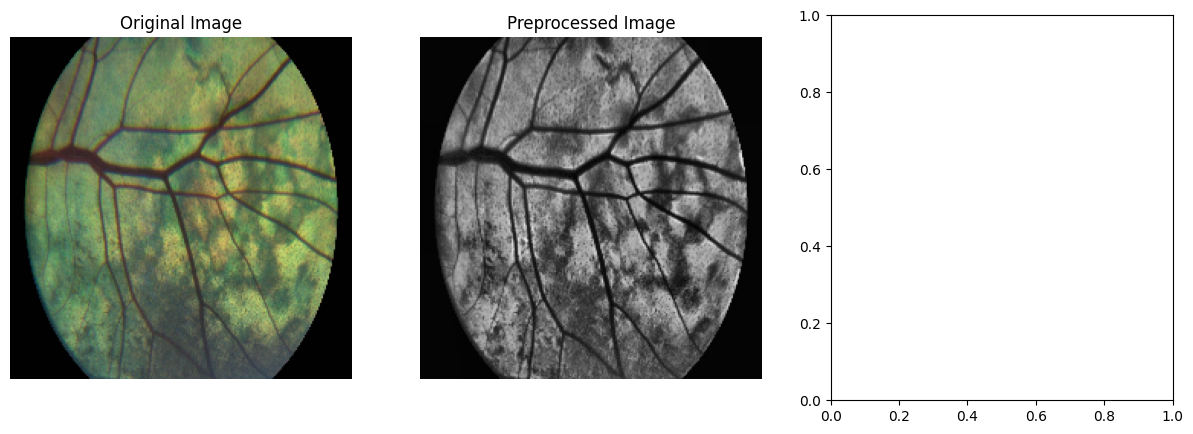

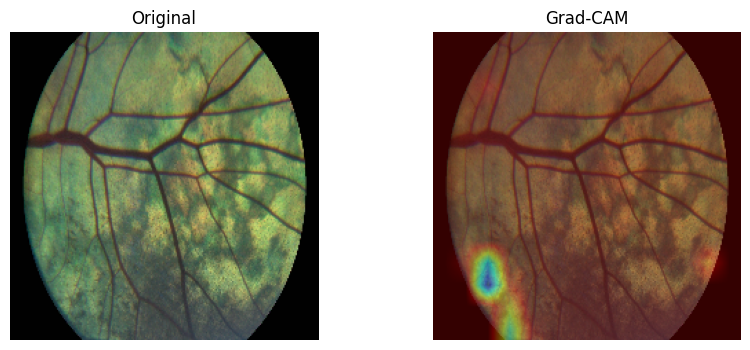

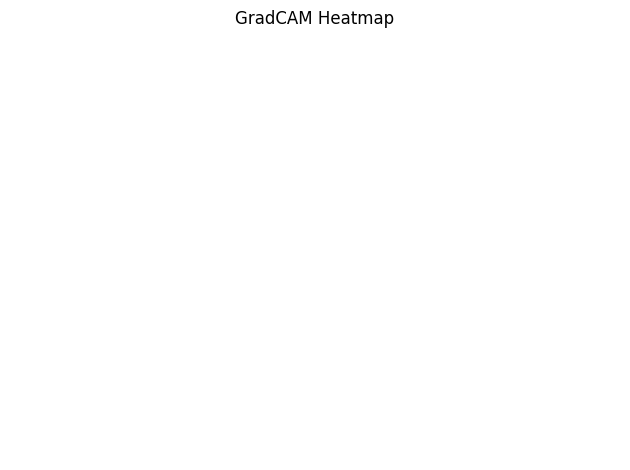


Preprocessing Steps Visualization:


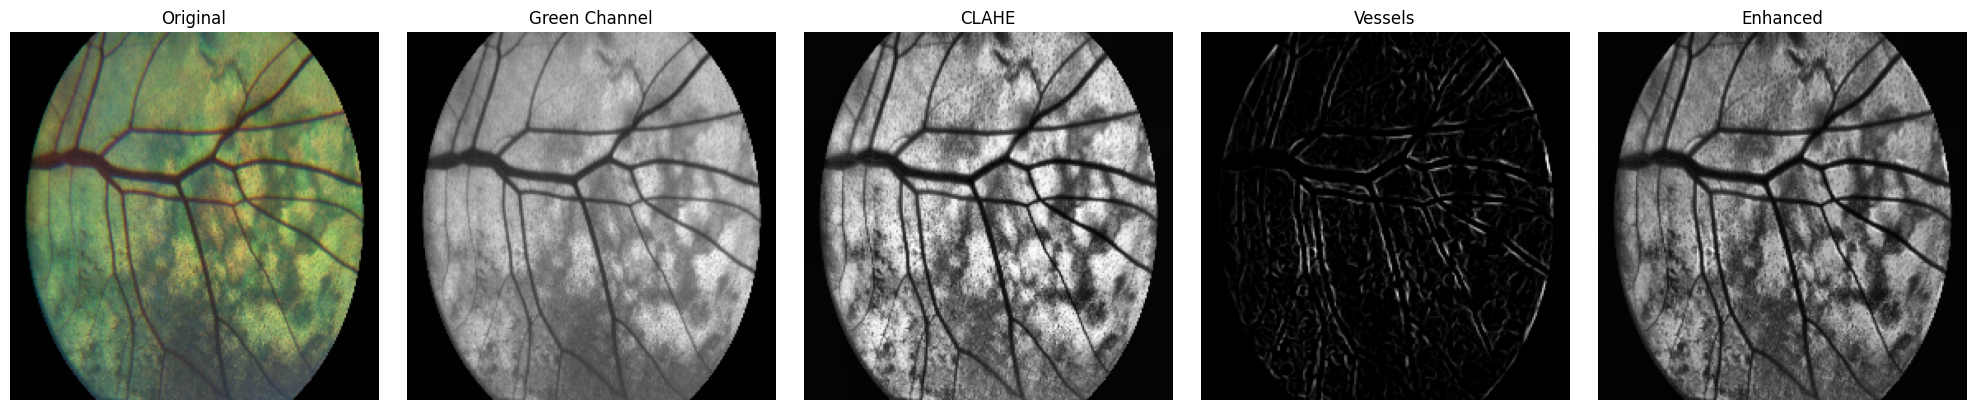

************************Starting Test Predictions for some samples**************************

Prediction Results:
--------------------
Probability: 0.532
Class: Abnormal
Threshold: 0.5
**************************Starting GradCAM Generation***************************


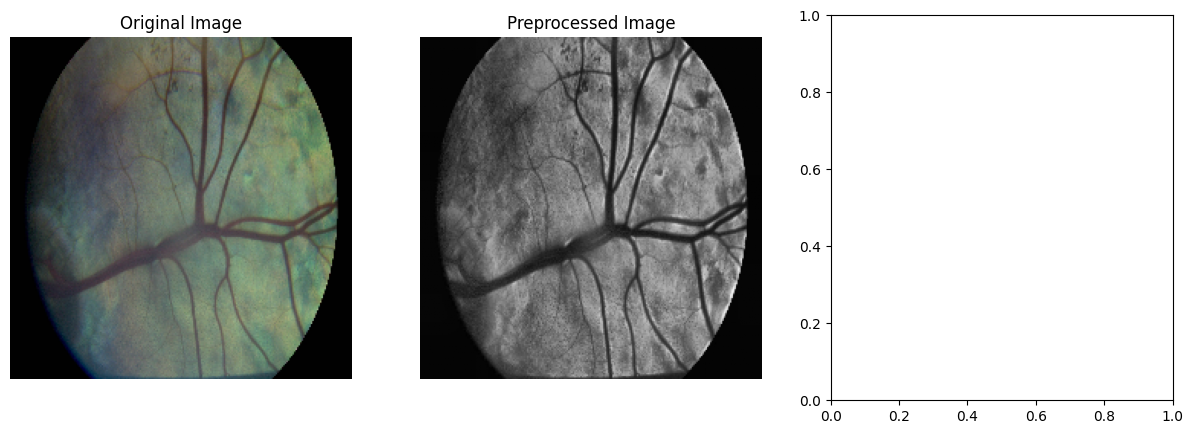

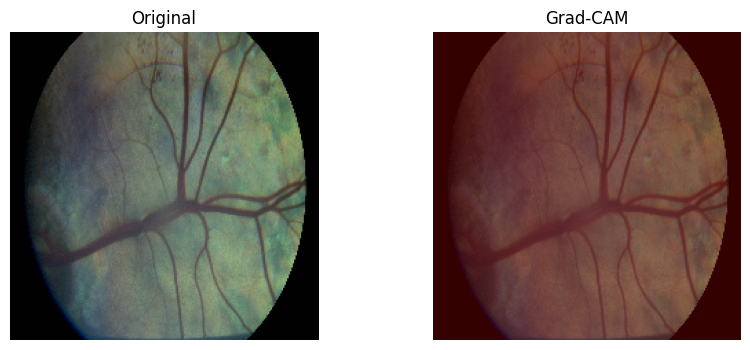

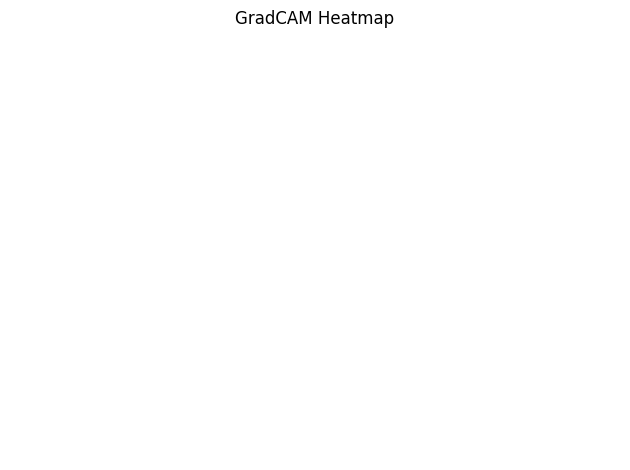


Preprocessing Steps Visualization:


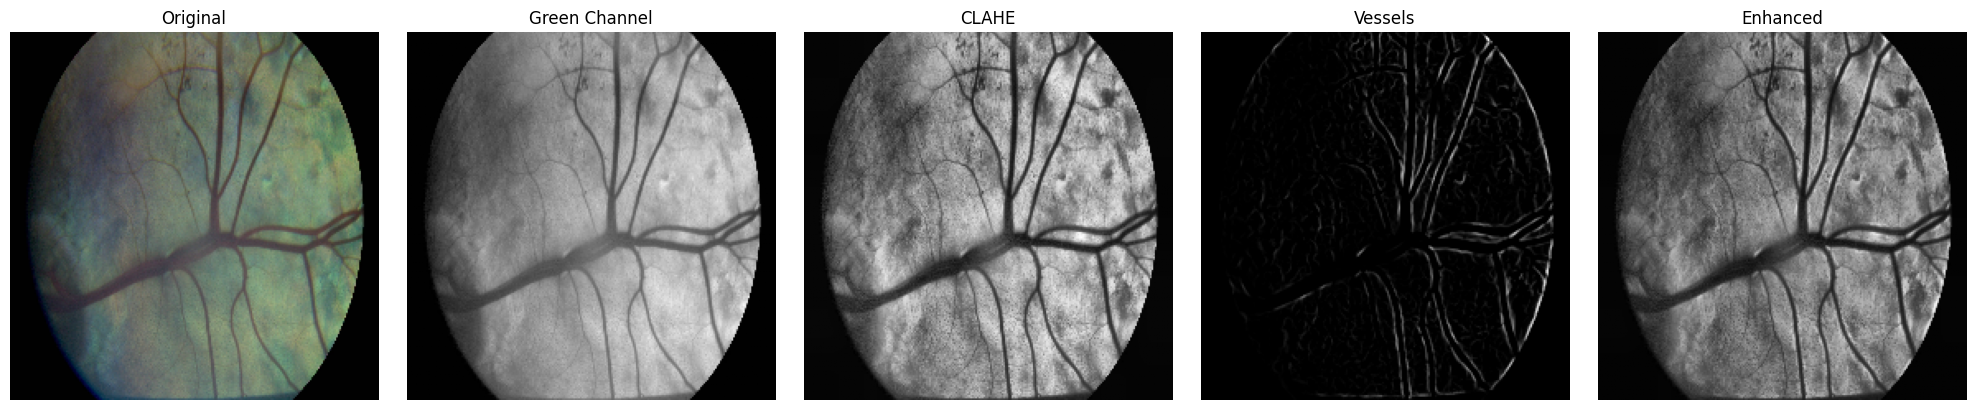


Batch Prediction Summary:
                                                path  probability     class  \
0           ..\artifacts\dataset\test\0\IM5005EY.JPG     0.586895  Abnormal   
1  ..\artifacts\dataset\test\1\032_01.1.060-1.02_...     0.531592  Abnormal   

   threshold  
0        0.5  
1        0.5  


In [17]:
# Single image prediction
# result = classifier.try_prediction(img_sample_dir_0)

# Batch prediction
image_paths = [img_sample_dir_0, img_sample_dir_1]
summary = classifier.visualize_batch_predictions(image_paths, num_samples=2)